In [2]:
# Imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle, Wedge, Polygon
import math
import os
import time
import itertools

import joblib

import warnings
warnings.filterwarnings('ignore')

from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection

from sklearn.metrics import pairwise_distances

#plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'monospace'
#plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

%matplotlib notebook

plt.rcParams['figure.figsize'] = [7, 7]

import torch
import torch.nn
import torch.utils.data
import torchvision

In [3]:
torch.__version__

'1.3.1'

In [2]:
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, 8)
        self.fc2 = torch.nn.Linear(8, 8)
        self.fc3 = torch.nn.Linear(8, 8)
        self.fc4 = torch.nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [3]:
def calcRegion(network, data):
    network.zero_grad()
    output = network(data)
    output = output[:, 1] - output[:, 0]
    g = torch.autograd.grad(torch.sum(output), data)[0].data
    
    weights = np.array(g.tolist())
    
    inputs = np.array(data.tolist())
    result = np.sum(np.multiply(weights,inputs), axis=1)
    biases = np.array(output.tolist()) - result
    
    regions = np.concatenate((weights, biases[:, None]), axis=1)
    
    return regions

def getRegions(network, dataLoader):
    regions = np.array([]).reshape(0, 3)
    for batch_idx, (data, target) in enumerate(dataLoader):
        data.requires_grad_()
        region = calcRegion(network, data)
        regions = np.concatenate((regions, region), axis=0)
        
    return np.array(regions)

In [4]:
def calcZs(network, bounds=2, res=201):
    As = []
    bs = []
    params = list(network.parameters())
    for i in range(0, len(params), 2):
        As.append(params[i].data.numpy())
        bs.append(params[i+1].data.numpy())
    
    
    x = np.linspace(-bounds, bounds, res)
    y = np.copy(x)

    X, Y = np.meshgrid(x, y)
    origShape = X.shape

    X = np.reshape(X, -1)
    Y = np.reshape(Y, -1)

    inputVal = np.vstack((X, Y))

    dataset = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(inputVal).T,torch.Tensor(inputVal).T), batch_size=10000)
    
    regions = getRegions(network, dataset)
    regions = np.unique(np.around(regions, decimals=2), axis=0)
    
    outs = []
    outs.append((np.matmul(As[0], inputVal).T + bs[0]).T)
    for i in range(1, len(As)):
        outs.append((np.matmul(As[i], np.maximum(outs[i-1], 0)).T + bs[i]).T)

    X = np.reshape(X, origShape)
    Y = np.reshape(Y, origShape)
    
    return X, Y, outs, regions

In [5]:
def plotNodeColored(X, Y, val, color, ax):
    Z = np.reshape(val, X.shape)
    ax.contour(X, Y, Z, [0], colors=color);
        
def plotLayerUncolored(X, Y, vals, alpha, ax):
    for i in range(vals.shape[0]):
        Z = np.reshape(vals[i, :], X.shape)
        ax.contour(X, Y, Z, [0], colors='k', alpha=alpha);
        
def plotLayersUncolored(X, Y, valList, ax):    
    alpha = 0.25
    
    for val in valList[::-1]:
        plotLayerUncolored(X, Y, val, alpha, ax)

In [6]:
def plotPolytopeRegions(X, Y, f, g, ax):
    origShape = X.shape

    X = np.reshape(X, -1)[:, None]
    Y = np.reshape(Y, -1)[:, None]

    inputVal = np.concatenate((X, Y), axis=1)

    fIndices = f.calcIndex(inputVal)
    gIndices = g.calcIndex(inputVal)

    combos = set()
    for i in range(fIndices.shape[0]):
        combos.add((fIndices[i], gIndices[i]))

    lRegions = []
    for elem in combos:
        lRegions.append(f.monomials[elem[0], :] - g.monomials[elem[1], :])
    lRegions = np.unique(lRegions, axis=0)
    
    ax.scatter(lRegions[:, 0], lRegions[:, 1], lRegions[:, 2])
    ax.set_title('Linear Regions\n{} regions'.format(lRegions.shape[0]))

In [7]:
accuracies = np.load('accuraciesCircleComplex.npy')
indices = np.load('indicesCircleComplex.npy')

Time taken to 999 is 6.0883073806762695
Time taken to 998 is 12.062731742858887
Time taken to 997 is 18.107428312301636
Time taken to 996 is 24.237899780273438
Time taken to 995 is 28.644617557525635
Time taken to 994 is 33.72354078292847
Time taken to 993 is 40.023860931396484
Time taken to 992 is 46.250298738479614
Time taken to 991 is 52.439371824264526
Time taken to 990 is 58.729363203048706
Time taken to 989 is 65.0753812789917
Time taken to 988 is 70.8894612789154
Time taken to 987 is 77.0451238155365
Time taken to 986 is 83.4183702468872
Time taken to 985 is 89.55337309837341
Time taken to 984 is 95.13239884376526
Time taken to 983 is 101.51607751846313
Time taken to 982 is 108.10340118408203
Time taken to 981 is 113.88441586494446
Time taken to 980 is 120.30439352989197
Time taken to 979 is 126.29103994369507
Time taken to 978 is 132.31916284561157
Time taken to 977 is 138.9094271659851
Time taken to 976 is 145.54541110992432
Time taken to 975 is 151.51738667488098
Time taken t

Time taken to 790 is 1438.871440410614
Time taken to 789 is 1449.1954340934753
Time taken to 788 is 1458.6004133224487
Time taken to 787 is 1468.1773982048035
Time taken to 786 is 1478.060376882553
Time taken to 785 is 1487.3273949623108
Time taken to 784 is 1497.2263760566711
Time taken to 783 is 1507.1643800735474
Time taken to 782 is 1516.7733976840973
Time taken to 781 is 1526.360366344452
Time taken to 780 is 1537.165376663208
Time taken to 779 is 1547.0646405220032
Time taken to 778 is 1556.3223893642426
Time taken to 777 is 1566.195402622223
Time taken to 776 is 1575.9123899936676
Time taken to 775 is 1585.487376689911
Time taken to 774 is 1594.871376991272
Time taken to 773 is 1604.7763681411743
Time taken to 772 is 1614.1643855571747
Time taken to 771 is 1623.8384110927582
Time taken to 770 is 1634.1253998279572
Time taken to 769 is 1643.621375799179
Time taken to 768 is 1653.1354112625122
Time taken to 767 is 1663.1213991641998
Time taken to 766 is 1673.0324177742004
Time tak

Time taken to 582 is 3276.048381090164
Time taken to 581 is 3285.593377828598
Time taken to 580 is 3295.442378282547
Time taken to 579 is 3305.205390691757
Time taken to 578 is 3315.5343799591064
Time taken to 577 is 3325.139377593994
Time taken to 576 is 3335.5373978614807
Time taken to 575 is 3345.2601380348206
Time taken to 574 is 3355.5713753700256
Time taken to 573 is 3365.0243661403656
Time taken to 572 is 3374.8634095191956
Time taken to 571 is 3384.668389081955
Time taken to 570 is 3394.5483736991882
Time taken to 569 is 3404.226371526718
Time taken to 568 is 3414.1093764305115
Time taken to 567 is 3424.8353955745697
Time taken to 566 is 3436.1383640766144
Time taken to 565 is 3446.6393694877625
Time taken to 564 is 3456.6923949718475
Time taken to 563 is 3466.804363012314
Time taken to 562 is 3476.757377386093
Time taken to 561 is 3487.066395521164
Time taken to 560 is 3496.9403731822968
Time taken to 559 is 3506.875368118286
Time taken to 558 is 3516.6194014549255
Time taken 

Time taken to 373 is 5342.712388753891
Time taken to 372 is 5353.6573984622955
Time taken to 371 is 5363.561398029327
Time taken to 370 is 5373.87739276886
Time taken to 369 is 5384.978407382965
Time taken to 368 is 5395.201375961304
Time taken to 367 is 5403.7374012470245
Time taken to 366 is 5412.216377019882
Time taken to 365 is 5421.583377122879
Time taken to 364 is 5431.243412733078
Time taken to 363 is 5442.550418138504
Time taken to 362 is 5452.703402996063
Time taken to 361 is 5462.108394384384
Time taken to 360 is 5471.886385440826
Time taken to 359 is 5481.721392869949
Time taken to 358 is 5491.850379943848
Time taken to 357 is 5501.674375534058
Time taken to 356 is 5511.59138417244
Time taken to 355 is 5521.712375402451
Time taken to 354 is 5531.741384506226
Time taken to 353 is 5541.711380958557
Time taken to 352 is 5551.465375423431
Time taken to 351 is 5561.394380807877
Time taken to 350 is 5571.196425437927
Time taken to 349 is 5581.085378408432
Time taken to 348 is 5591

Time taken to 163 is 7254.590365409851
Time taken to 162 is 7260.194381713867
Time taken to 161 is 7266.519382476807
Time taken to 160 is 7273.200413942337
Time taken to 159 is 7279.724681377411
Time taken to 158 is 7287.137447357178
Time taken to 157 is 7293.692186117172
Time taken to 156 is 7300.134422540665
Time taken to 155 is 7306.188099861145
Time taken to 154 is 7313.3083753585815
Time taken to 153 is 7319.610411167145
Time taken to 152 is 7326.285380363464
Time taken to 151 is 7333.725373029709
Time taken to 150 is 7341.148370027542
Time taken to 149 is 7348.377363681793
Time taken to 148 is 7355.3383820056915
Time taken to 147 is 7362.3893847465515
Time taken to 146 is 7368.8262820243835
Time taken to 145 is 7375.5523681640625
Time taken to 144 is 7381.605364322662
Time taken to 143 is 7387.19541478157
Time taken to 142 is 7393.983408212662
Time taken to 141 is 7400.407448768616
Time taken to 140 is 7407.075278997421
Time taken to 139 is 7413.472373723984
Time taken to 138 is 

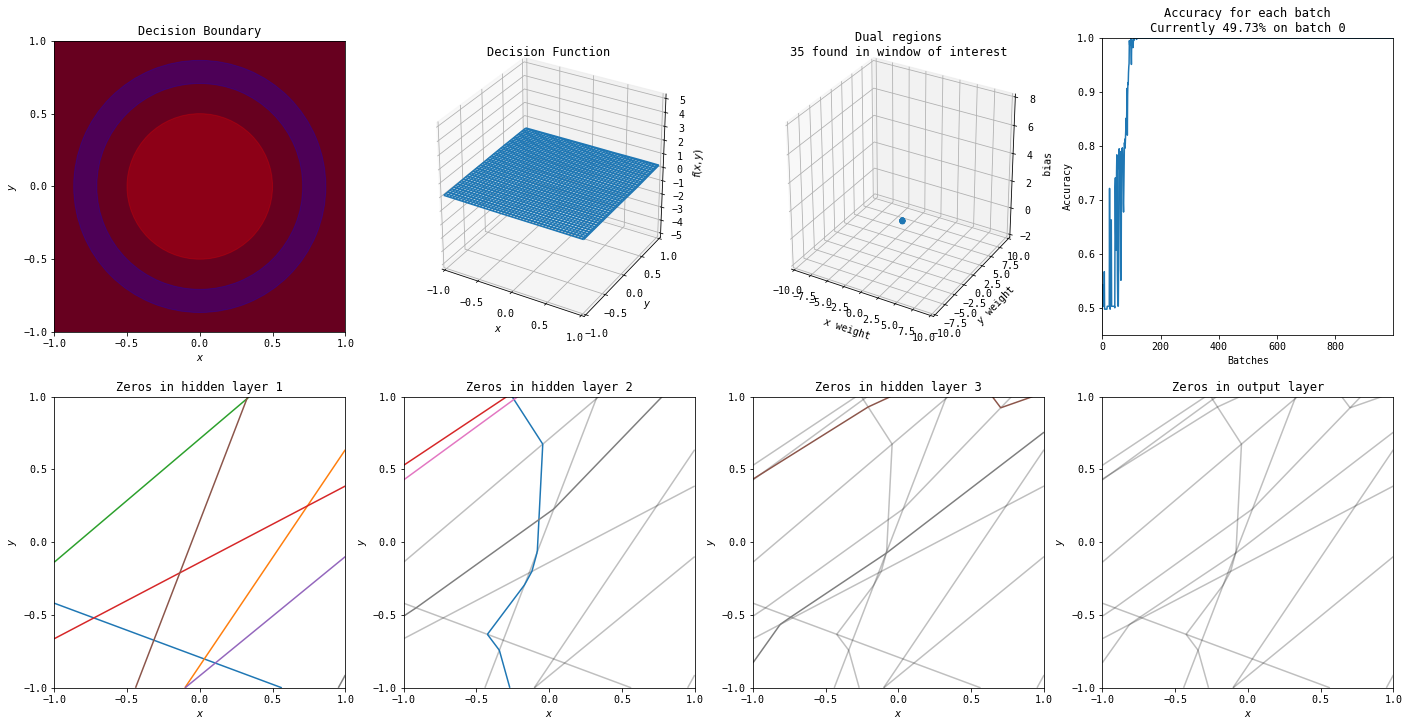

In [8]:
fig = plt.figure(figsize=(24, 12))

axDecision=fig.add_subplot(241)
axWireframe=fig.add_subplot(242, projection='3d')
axRegions=fig.add_subplot(243, projection='3d')
axAccuracies=fig.add_subplot(244)

axFirst = fig.add_subplot(245)
axSecond = fig.add_subplot(246)
axThird = fig.add_subplot(247)
axFourth = fig.add_subplot(248)

axPolytopes = [axFirst, axSecond, axThird, axFourth]

# Get rid of gray
colors = list(matplotlib.colors.TABLEAU_COLORS.keys())

r1 = 0.5
r2 = np.sqrt(2*r1**2)
r3 = np.sqrt(3*r1**2)

start = time.time()
for i in indices[::-1]:
    
    network = torch.load('trainedNetsCircleComplex/network{:09d}.pt'.format(i))
    X, Y, outs, regions = calcZs(network, bounds=1, res=401)

    for ax in [axDecision, axFirst, axSecond, axThird, axFourth]:
        ax.clear()
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_xticks(np.arange(-1, 1.5, 0.5))
        ax.set_yticks(np.arange(-1, 1.5, 0.5))
        ax.set_aspect('equal')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        
    axWireframe.clear()
    axWireframe.set_xlim([-1, 1])
    axWireframe.set_ylim([-1, 1])
    axWireframe.set_xticks(np.arange(-1, 1.5, 0.5))
    axWireframe.set_yticks(np.arange(-1, 1.5, 0.5))
    #axWireframe.set_zticks([])
    axWireframe.set_title('Decision Function')
    axWireframe.set_xlabel('$x$')
    axWireframe.set_ylabel('$y$')
    axWireframe.set_zlabel('$f(x, y)$')
    axWireframe.set_zlim([-5.1, 5.1])
    axWireframe.set_zticks(range(-5, 6))
    
    axRegions.clear()
    axRegions.scatter(regions[:, 0], regions[:, 1], regions[:, 2])
    axRegions.set_title('Dual regions\n{} found in window of interest'.format(regions.shape[0]))
    axRegions.set_xlabel('$x$ weight')
    axRegions.set_ylabel('$y$ weight')
    axRegions.zaxis.set_rotate_label(True)
    axRegions.set_zlabel('bias')
    
    axRegions.set_xlim([-10, 10])
    axRegions.set_ylim([-10, 10])
    axRegions.set_zlim([-2, 8])
    
    # Accuracy
    axAccuracies.clear()
    axAccuracies.plot(accuracies)
    axAccuracies.set_xlabel('Batches')
    axAccuracies.set_ylabel('Accuracy')
    axAccuracies.set_ylim([0.45, 1.0])
    axAccuracies.set_xlim([0, indices[-1]])
    axAccuracies.plot([i, i], [0, 100], 'k', alpha=0.5)
    axAccuracies.set_title('Accuracy for each batch\nCurrently {:.2f}% on batch {}'.format(100*accuracies[i], i))
    
    output = outs[-1][1] - outs[-1][0]
    output = output.reshape(X.shape)

    # Raw outputs
    axDecision.contourf(X, Y, output, vmin=-0.001, vmax=0.001,cmap='RdBu_r')
    axDecision.set_title('Decision Boundary')
    
    circle = Circle((0, 0), 0.5, color='r', alpha=0.25)
    annulus = Wedge((0, 0), r3, 0, 360, width=r3-r2, color='b', alpha=0.25)
    axDecision.add_artist(circle)
    axDecision.add_artist(annulus)
    
    # Wireframe
    axWireframe.plot_wireframe(X, Y, output)
    
    # Polytope construction
    for k in range(3):
        if k > 0:
            plotLayersUncolored(X, Y, outs[:k], axPolytopes[k])
        for j in range(len(outs[k])):
            plotNodeColored(X, Y, outs[k][j], colors[j], axPolytopes[k])
        axPolytopes[k].set_title('Zeros in hidden layer {}'.format(k+1))
        
    plotLayersUncolored(X, Y, outs[:-1], axPolytopes[-1])
    plotNodeColored(X, Y, output, colors[0], axPolytopes[-1])
    axPolytopes[-1].set_title('Zeros in output layer')

    fig.show()
    fig.canvas.draw()

    fig.savefig('circleTrainingComplex/{:09d}.png'.format(i), bbox_inches='tight')

    time.sleep(1)
    
    print('Time taken to {} is {}'.format(i, time.time()-start))

In [11]:
os.system('ffmpeg -r 5 -i circleTrainingComplex/%09d.png -r 5 circleTrainingComplex.mp4')

0

In [10]:
os.system('notify-send "finished video"')

0